In [1]:
using Revise
using LinearAlgebra
using SparseArrays
using Pkg
using DelayDiffEq 
using Plots
using BenchmarkTools

In [2]:
using OpenQuantumSystems

┌ Info: Precompiling OpenQuantumSystems [90e503ea-487f-4e8e-81fe-8dcc9db25ac5]
└ @ Base loading.jl:1342


In [ ]:
D(op1::Array, op2::Array) = abs(norm(op1 - op2))
D(x1::StateVector, x2::StateVector) = norm(x2 - x1)
D(op1::AbstractOperator, op2::AbstractOperator) = abs(tracedistance_nh(dense(op1), dense(op2)))
D(op1::AbstractSuperOperator, op2::AbstractSuperOperator) = abs(tracedistance_nh(dense(op1), dense(op2)))

HR = 0.01
shift = (2.0 * HR)
modes = [Mode(180., shift)]
mols = [
        Molecule([Mode(180., shift)], 3, [12500., 12700.]),
        Molecule([Mode(180., shift)], 3, [12500., 12700.])
    ]

aggCore = AggregateCore(mols)
for mol_i in 2:aggCore.molCount
    aggCore.coupling[mol_i, mol_i+1] = 50
    aggCore.coupling[mol_i+1, mol_i] = 50
end
agg = setupAggregate(aggCore)
aggCore = agg.core
aggTools = agg.tools
aggOperators = agg.operators

Ham_sys = agg.operators.Ham_sys
Ham_bath = agg.operators.Ham_bath
Ham_S = agg.operators.Ham_S
Ham_B = agg.operators.Ham_B
Ham_I = agg.operators.Ham_I
Ham_0 = agg.operators.Ham_0
Ham = agg.operators.Ham

basis = agg.tools.basis
indicesLen = agg.tools.bSize
indices = agg.tools.indices
indicesMap = agg.tools.indicesMap
FCFact = agg.tools.FCfactors
FCProd = agg.tools.FCproduct

Ham_0
Ham_0_lambda, Ham_0_S = eigen(Ham_0.data)
Ham_0_Sinv = inv(Ham_0_S)
Ham_0_lambda = diagm(Ham_0_lambda)
println("")

In [ ]:
t_max = 0.01
t_count = 200
t0 = 0.
t_step = (t_max - t0) / (t_count)
tspan = [t0:t_step:t_max;]

T = 300
mu_array = [[2, 1]]
W0_1 = thermal_state(T, [[2, 1]], aggCore, aggTools, aggOperators; diagonalize = true)
W0_2 = thermal_state(T, [[1, 2]], aggCore, aggTools, aggOperators; diagonalize = true)
W0_3 = DenseOperator(W0_1.basis_l, W0_1.basis_r, zero(W0_1.data))
W0_4 = DenseOperator(W0_1.basis_l, W0_1.basis_r, zero(W0_1.data))
a1 = indicesMap[2][1]; a2 = indicesMap[2][end]
b1 = indicesMap[3][1]; b2 = indicesMap[3][end]
W0_3.data[a1:a2, b1:b2] = W0_2.data[b1:b2, b1:b2]
W0_4.data[b1:b2, a1:a2] = W0_2.data[b1:b2, b1:b2]
W0 = 0.8*W0_1 + 0.2*W0_2 + 0.1*W0_3 + 0.1*W0_4
W0 = DenseOperator(W0.basis_l, W0.basis_r, complex(W0.data))

# data = Matrix(Hermitian(rand(ComplexF64, indicesLen, indicesLen)))
# W0 = DenseOperator(basis, basis, data)
# normalize!(W0)

W0_bath = get_rho_bath(W0, aggCore, aggTools)
W0_bath = DenseOperator(W0_bath.basis_l, W0_bath.basis_r, complex(W0_bath.data))

rho0 = trace_bath(W0, aggCore, aggTools)
rho0 = DenseOperator(rho0.basis_l, rho0.basis_r, complex(rho0.data))

println("")

In [32]:
BenchmarkTools.DEFAULT_PARAMETERS.samples = 5
BenchmarkTools.DEFAULT_PARAMETERS.seconds = 60
using OpenQuantumSystems
@time T, W_int_t = QME_SS_exact(
    W0,
    tspan,
    agg;
    reltol = 1e-4,
    abstol = 1e-4,
    int_reltol = 1e-5,
    int_abstol = 1e-5,
    alg = DelayDiffEq.MethodOfSteps(DelayDiffEq.Tsit5()),
)

In [30]:
W_t_exact = zeros(ComplexF64, length(tspan), agg.tools.bSize, agg.tools.bSize)
t_i = 0

for t_i in 1:length(tspan)
    t = tspan[t_i]
    U_op = evolutionOperator(Ham, t)
    W = U_op * W0 * U_op'
    # U_0_op = evolutionOperator(Ham_0, t)
    # W_int = U_0_op' * W * U_0_op
    W_t_exact[t_i, :, :] = W.data
end

1 0.0
2 4.823024252441865e-16
3 2.8090025351230844e-15
4 9.127748982825977e-15
5 2.301378963096839e-14
6 4.785713594762875e-14
7 8.627625539383796e-14
8 1.391494787638888e-13
9 2.0674908005940783e-13
10 2.8831512191777437e-13
11 3.8281882714938617e-13
12 4.892810782638938e-13
13 6.051024786492733e-13
14 7.29288668427366e-13
15 8.605794642345374e-13
16 9.98076929531036e-13
17 1.140995651708217e-12
18 1.29060800370679e-12
19 1.4484993644853334e-12
20 1.6179417211605685e-12
21 1.8027544002188748e-12
22 2.0101389487663804e-12
23 2.2475195717676834e-12
24 1.8128628718697515e-12
25 2.8153617190665725e-12
26 7.2576298680924946e-12
27 1.362513132564995e-11
28 2.151388523000446e-11
29 3.070647266950483e-11
30 4.1020048113992984e-11
31 5.228629432743724e-11
32 6.435021524496052e-11
33 7.706214686180227e-11
34 9.028375459025528e-11
35 1.0388305762053436e-10
36 1.1773612972406527e-10
37 1.3172707035803145e-10
38 1.4574714258550693e-10
39 1.596937879986165e-10
40 1.7347192106484407e-10
41 1.8699327

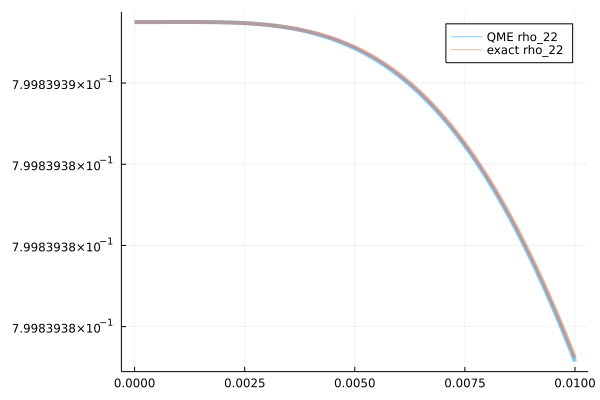

In [31]:

elLen = aggCore.molCount
rho_t = zeros(ComplexF64, length(tspan), elLen+1, elLen+1)
rho_t_exact = zeros(ComplexF64, length(tspan), elLen+1, elLen+1)

for t_i in 1:length(tspan)
    # rho_t[t_i, :, :] = W_int_t[t_i].data
    rho_t[t_i, :, :] = trace_bath(W_int_t[t_i].data, aggCore, aggTools)
    rho_t_exact[t_i, :, :] = trace_bath(W_t_exact[t_i, :, :], aggCore, aggTools)
    println(t_i, " ", D(rho_t[t_i, :, :], rho_t_exact[t_i, :, :]))
end

plot(tspan, real(rho_t[:, 2, 2]), label="QME rho_22", linealpha = 0.5, linewidth = 4, linestyle = :solid)
plot!(tspan, real(rho_t_exact[:, 2, 2]), label="exact rho_22", linealpha = 0.5, linewidth = 4, linestyle = :solid)

In [5]:
using OpenQuantumSystems
include("test_master.jl")


master: Error During Test at c:\Users\daniel.herman\Documents\Mgr\OpenQuantumSystems\OpenQuantumSystems.jl\test\test_master.jl:8
  Got exception outside of a @test
  UndefVarError: master_int not defined
  Stacktrace:
    [1] macro expansion
      @ c:\Users\daniel.herman\Documents\Mgr\OpenQuantumSystems\OpenQuantumSystems.jl\test\test_master.jl:59 [inlined]
    [2] macro expansion
      @ C:\buildbot\worker\package_win64\build\usr\share\julia\stdlib\v1.6\Test\src\Test.jl:1151 [inlined]
    [3] top-level scope
      @ c:\Users\daniel.herman\Documents\Mgr\OpenQuantumSystems\OpenQuantumSystems.jl\test\test_master.jl:10
    [4] include(fname::String)
      @ Base.MainInclude .\client.jl:444
    [5] top-level scope
      @ In[5]:2
    [6] eval
      @ .\boot.jl:360 [inlined]
    [7] include_string(mapexpr::typeof(REPL.softscope), mod::Module, code::String, filename::String)
      @ Base .\loading.jl:1116
    [8] softscope_include_string(m::Module, code::String, filename::String)
      @ So

LoadError: LoadError: [91mSome tests did not pass: 0 passed, 0 failed, 1 errored, 0 broken.[39m
in expression starting at c:\Users\daniel.herman\Documents\Mgr\OpenQuantumSystems\OpenQuantumSystems.jl\test\test_master.jl:8

In [8]:
names = [
    "test_operators_dense.jl",
    "test_superoperators.jl",
    "test_metrics.jl",
    "test_molecules.jl",
    "test_aggregateCore.jl",
    "test_aggregateTools.jl",
    "test_aggregateOperators.jl",
    "test_aggregate.jl",
    "test_evolution.jl",
    "test_schroedinger.jl",
    "test_liouville.jl",
    "test_interaction_picture.jl",
    "test_master.jl",
    "test_trace.jl",
    "test_initial_state.jl",
    "test_memory_kernel.jl",
    "test_master_ansatz.jl",
]

for name in names
    include(name)
end

Test Summary:   | Pass  Total
operators dense |    6      6
Test Summary:  | Pass  Total
superoperators |    2      2
Test Summary: | Pass  Total
metrics       |   19     19
Test Summary: | Pass  Total
molecules     |   20     20
Test Summary: | Pass  Total
aggregateCore |   14     14
Test Summary:  | Pass  Total
aggregateTools |   12     12
Test Summary:      | Pass  Total
aggregateOperators |    7      7
Test Summary: | Pass  Total
aggregate     |    3      3
Test Summary: | Pass  Total
evolution     |   54     54
Test Summary: | Pass  Total
schroedinger  |   25     25
Test Summary: | Pass  Total
liouville     |   11     11
Test Summary:       | Pass  Total
interaction picture |    9      9
Test Summary: |
master        | No tests
Test Summary: | Pass  Total
trace         |   41     41
Test Summary: | Pass  Total
initial state |    8      8
Test Summary: | Pass  Total
memory kernel |   51     51
Test Summary: |
master ansatz | No tests
